In [1]:
from nutils import*
from nutils.pointsseq import PointsSequence
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, collections, cm
import os

In [13]:
# Default inputs
#
# number of elements
Nb = 10
Na = 10
Nt = 10
# domain lengths
Lb = 1
La = 1
# hole radius
epsilon = Lb / 20
# basis degree
basis_degree = 2
# blood material props
E_b = 1 # MPa
nu_b = 0.0
# artery material properties
E_a = 10 # MPa
nu_a = 0.3
# blood pressure
pi = .012 # Mpa
# bias
delta = 0
# material projection
mat_degree = 3
project = False
# sample resolution
nsamples = 20

In [2]:
def locatesample(fromsample, fromgeom, totopo, togeom, tol, dim=2, **kwargs):
    '''Clone ``fromsample`` onto unrelated topology ``totopo``

    Create a sample ``tosample`` of ``totopo`` such that ``fromgeom`` and
    ``togeom`` are equal on the respective samples and such that integrals are
    equal.

    Parameters
    ----------
    fromsample: :class:`nutils.sample.Sample`
      The sample to be located in ``totopo``.
    fromgeom: :class:`nutils.function.Array`
      The geometry evaluable on ``fromsample``.
    totopo: :class:`nutils.topology.Topology`
      The topology to create ``tosample`` on.
    togeom: :class:`nutils.function.Array`
      The geometry evaluable on ``totopo``.
    **kwargs:
      All keyword arguments are passed to
      :meth:`nutils.topology.Topology.locate`.

    Returns
    -------
    tosample: :class:`nutils.sample.Sample`
      The sample of ``totopo``.

    '''

    tosample = totopo.locate(togeom, fromsample.eval(fromgeom), tol=tol, **kwargs)

    # Copy the weights from `fromsample` and account for the change in local
    # coordinates via the common geometry.
    weights = fromsample.eval(function.J(fromgeom)) / tosample.eval(function.J(togeom))
    for p, i in zip(fromsample.points, fromsample.index):
        weights[i] = p.weights
    weightedpoints = tuple(points.CoordsWeightsPoints(p.coords, weights[i]) for p, i in zip(tosample.points, tosample.index))
    weightedpoints = PointsSequence.from_iter(weightedpoints, dim)
    return sample.Sample.new(tosample.transforms, weightedpoints, tosample.index)

In [15]:
# Exact 1D Solutions
def Exact(ri, ro, pi, E, nu, n, vals):
    exact = function.Namespace()
    topo, exact.x = mesh.rectilinear([np.linspace(ri,ro,n+1)])
    sample = topo.sample('bezier', 2)
    exact.r = 'x_0'
    exact.pi = pi
    exact.ri = ri
    exact.ro = ro
    exact.nu = nu
    exact.E = E
    exact.sigmatt = '((pi ri^2) / (ro^2 - ri^2)) + ((pi) ri^2 ro^2) / (r^2 (ro^2 - ri^2))'
    exact.sigmarr = '((pi ri^2) / (ro^2 - ri^2)) - ((pi) ri^2 ro^2) / (r^2 (ro^2 - ri^2))'
    exact.sigmazz = '2 nu (pi ri^2) / (ro^2 - ri^2)'
    exact.meanstress = '( sigmatt + sigmarr + sigmazz ) / 3'
    exact.vonmises = 'sqrt(  ( (sigmarr - sigmatt)^2 + (sigmatt - sigmazz)^2 + (sigmazz - sigmarr)^2  ) / 2  )'
    exact.d1 = '(1 + nu) ri^2 ro^2 / (E (ro^2 - ri^2))'
    exact.d2 = '( (1 - 2 nu) pi ) / ro^2'
    exact.ur = 'd1 ( (pi / r ) + d2 r )'
    exact.epsrr = '(- d1 pi / r^2) + d1 d2'
    
    results = {}
    
    for key in vals:
        results[key] = sample.eval(key @ exact)
    
    return results

In [16]:
def Plot(figs, plots, xlabels, ylabels, results, exact, legend):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for fig in figs:
        figure = plt.figure(figsize=(10,10))
        ax = figure.add_subplot(1,1,1)
        ax.set_xlabel(xlabels[fig])
        ax.set_ylabel(ylabels[fig])
        ax.set_title(figs[fig])
        for plot in plots[fig]:
            if plot in exact:
                ax.plot(exact["r"], exact[plot], 'k--')
            for col, case in zip(colors,results): 
                ax.plot(results[case]["r"], results[case][plot], color=col)
        ax.legend(np.concatenate([["exact"],[case for case in cases]]))
        plt.show()
    
def BodyFittedThickWalledCylinder(ri, ro, pi, E, nu, Nr, Nt, p, n, vals1d, vals2d):
    
    # define Namespace
    ns = function.Namespace()
    
    # Build Mesh
    r = np.linspace(ri, ro, Nr + 1)
    t = np.linspace(0, np.pi/2, Nt + 1)
    topo, ns.uv = mesh.rectilinear([t,r])
    ns.x_i = '<uv_1 cos(uv_0) , uv_1 sin(uv_0) >_i'
    
    # plot mesh
    #sample_verts = topo.sample('bezier', 2)
    #fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(1,1,1)
    #x_vals, vals = sample_verts.eval([ns.x, 0])
    #ax.tripcolor(x_vals[:,0], x_vals[:,1], sample_verts.tri, vals, shading='gouraud', rasterized=True)
    #plt.show()
    
    # Define Basis
    ns.basis = topo.basis('spline', degree=p)
    
    # Define Material properties
    ns.E = E
    ns.nu = nu
    ns.mu = 'E / (2 (1 + nu))'
    ns.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'
    
    # Setup Analysis
    ns.pi = pi
    ns.ubasis = ns.basis.vector(2)
    ns.u_i = 'ubasis_ni ?lhs_n'
    ns.strain_ij = '(u_i,j + u_j,i) / 2'
    ns.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
    ns.X_i = 'x_i + u_i'
    ns.disp = 'sqrt(u_i u_i)'
    ns.r = 'sqrt( x_i x_i )'
    ns.cos = 'x_0 / r'
    ns.sin = 'x_1 / r'
    ns.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
    ns.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
    ns.du_i = 'Qinv_ij u_j'
    ns.sigmatt = 'sigma_11'
    ns.sigmarr = 'sigma_00'
    ns.ur = 'du_0'

    # Stiffness matrix
    K = topo.integral('ubasis_ni,j stress_ij d:x' @ ns, degree = np.max([1, 2 * (p-1)]))

    # Force Vector
    F = topo.boundary['bottom'].integral('ubasis_ni pi n_i d:x' @ ns, degree=np.max([1,p+2]))

    # Constrain Omega
    sqr  = topo.boundary['left'].integral('u_1 u_1 d:x' @ ns, degree = 2 * basis_degree)
    sqr += topo.boundary['right'].integral('u_0 u_0 d:x' @ ns, degree = 2 * basis_degree)
    cons = solver.optimize('lhs', sqr, droptol=1e-11)

    # Solve
    lhs = solver.solve_linear('lhs', residual=K+F, constrain=cons)
    
    # initialize results
    results = {}
    
    # sample 2d
    sample_2d = topo.sample('bezier', 3)
    x_vals = sample_2d.eval(ns.x)
    for key in vals2d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        vals = sample_2d.eval(key @ ns, lhs=lhs)
        ax.tripcolor(x_vals[:,0], x_vals[:,1], sample_2d.tri, vals, shading='gouraud', rasterized=True)
        plt.show()
    
    
    # sample 1d
    eps = (ro - ri) / (2 * Nr)
    s = function.Namespace()
    slice_topo, s.t = mesh.rectilinear([np.linspace(ri+eps,ro-eps,n)])
    s.theta = np.pi / 4 
    s.x_i = '<t_0 cos(theta) , t_0 sin(theta)>_i'
    sample_1d = locatesample(slice_topo.sample('gauss', 1), s.x, topo, ns.x, tol=1e-7, maxiter=1000, eps=1e-5)
    for key in vals1d:
        results[key] = sample_1d.eval(key @ ns, lhs=lhs)
    
    
    return results


def RunBodyFittedThickWalledCylinder(ri, ro, pi, E, nu, Nt, Nr, p, n, vals1d, vals2d, cases):
    # initialize results
    results = {}
    ncases = len(cases)
    
    # Convert scalars to arrays in order to standardize the input
    if np.isscalar(ri):
        ri = [ri for i in range(ncases)]
    if np.isscalar(ro):
        ro = [ro for i in range(ncases)]
    if np.isscalar(pi):
        pi = [pi for i in range(ncases)]
    if np.isscalar(E):
        E = [E for i in range(ncases)]
    if np.isscalar(nu):
        nu = [nu for i in range(ncases)]
    if np.isscalar(Nt):
        Nt = [Nt for i in range(ncases)]
    if np.isscalar(Nr):
        Nr = [Nr for i in range(ncases)]
    if np.isscalar(p):
        p = [p for i in range(ncases)]
    if np.isscalar(n):
        n = [n for i in range(ncases)]
        
    # Make sure arrays are same size in order to standardize the input    
    if len(ri) != ncases:
        ri = [ri[0] for i in range(ncases)]
    if len(ro) != ncases:
        ro = [ro[0] for i in range(ncases)]
    if len(pi) != ncases:
        pi = [pi[0] for i in range(ncases)]
    if len(E) != ncases:
        E = [E[0] for i in range(ncases)]
    if len(nu) != ncases:
        nu = [nu[0] for i in range(ncases)]
    if len(Nt) != ncases:
        Nt = [Nt[0] for i in range(ncases)]
    if len(Nr) != ncases:
        Nr = [Nr[0] for i in range(ncases)]
    if len(p) != ncases:
        p = [p[0] for i in range(ncases)]
    if len(n) != ncases:
        n = [n[0] for i in range(ncases)]
    
    for i in range(ncases):
        results[cases[i]] = BodyFittedThickWalledCylinder(ri[i], ro[i], pi[i], E[i], nu[i], Nt[i], Nr[i], p[i], n[i], vals1d, vals2d)
    
    return results

BODY FITTED MESH - NO INTERFACE ( PRESSURIZED CYLINDER )

optimize > constrained 24/288 dofs
optimize > optimum value 0.00e+00
solve > solving 264 dof system to machine precision using arnoldi solver
solve > solver returned with residual 4e-17
solve > solving 4 dof system to machine precision using arnoldi solver
solve > solver returned with residual 0e+00
optimize > constrained 44/968 dofs
optimize > optimum value 0.00e+00
solve > solving 924 dof system to machine precision using arnoldi solver
solve > solver returned with residual 8e-17
solve > solving 4 dof system to machine precision using arnoldi solver
solve > solver returned with residual 0e+00
optimize > constrained 84/3528 dofs
optimize > optimum value 0.00e+00
solve > solving 3444 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-16
solve > solving 4 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-13


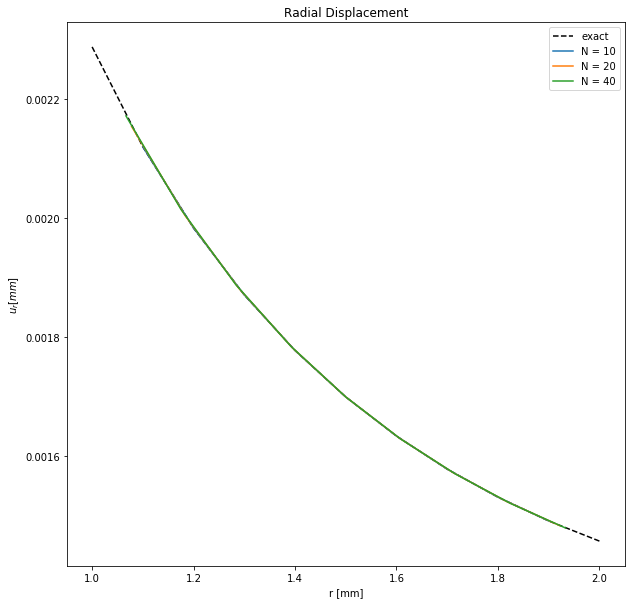

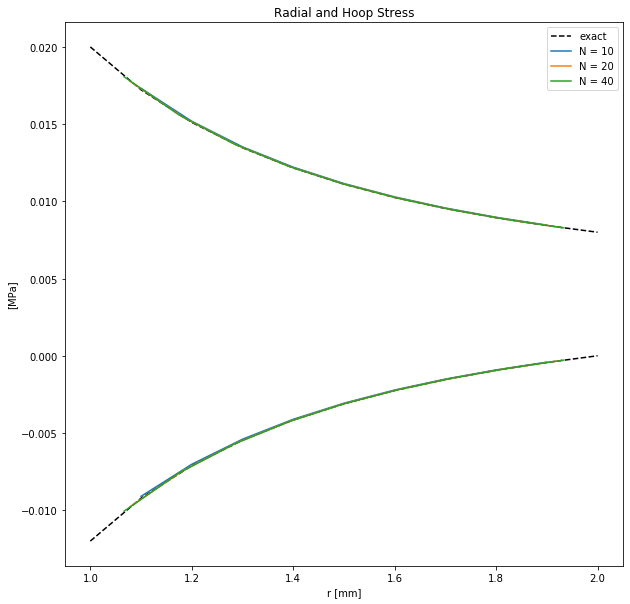

In [18]:
ri = Lb
ro = Lb + La
E = 10
nu = 0.3
N = [10,20,40]
p = 2
n = 10

#vals2d = ["sigmarr", "sigmatt", "ur"]
vals2d = {}
vals1d = {"r" : "r", "sigmarr" : "$\sigma_{rr}$", "sigmatt" : "$\sigma_{\\theta \\theta}$", "ur" : "$u_{r}$"}
cases = ["N = 10", "N = 20", "N = 40"]
figs = {"disp" : "Radial Displacement", "stress" : "Radial and Hoop Stress"}
plots = {"disp" : ["ur"], "stress" : ["sigmarr", "sigmatt"]}
xlabels = {"disp" : "r [mm]", "stress" : "r [mm]"}
ylabels = {"disp" : "$ u_{r} [mm]$", "stress" : "[MPa]"}

results = RunBodyFittedThickWalledCylinder(ri, ro, pi, E, nu, N, N, p, n, vals1d, vals2d, cases)
exact = Exact(ri, ro, pi, E, nu, n, vals1d)

Plot(figs, plots, xlabels, ylabels, results, exact, vals1d)


In [25]:
def RefineBySDF(topo, sdf, nrefine, dim=2):
    refined_topo = topo
    for n in range(nrefine):
        elems_to_refine = []
        k = 0
        bez = refined_topo.sample('bezier',2)
        sd = bez.eval(sdf)
        sd = sd.reshape( [len(sd)//2**dim, 2**dim] )
        for i in range(len(sd)):
            if any(np.sign(sdval) != np.sign(sd[i][0]) for sdval in sd[i,:]):
                elems_to_refine.append(k)
            k = k + 1
        refined_topo = refined_topo.refined_by(refined_topo.transforms[np.array(elems_to_refine)])
    return refined_topo

def ImmersedThickWalledCylinder(ri, ro, L, E_b, nu_b, E_a, nu_a, pi, Nx, Ny, Nu, p, q, pg, nref, nqref, n, vals1d, vals2d):

    # mat prop functions
    class PoissonRatio(function.Pointwise):
        @staticmethod
        def evalf(x,y):
            return nu_b + (nu_a - nu_b) * np.heaviside(x**2 + y**2 - ri**2 ,1) - (nu_a - nu_b)*np.heaviside(x**2 + y**2 - ro**2 ,0)
        def _derivative(self, var, seen):
            return np.zeros(self.shape+var.shape)

    class YoungsModulus(function.Pointwise):
        @staticmethod
        def evalf(x,y):
            return E_b + (E_a - E_b) * np.heaviside(x**2 + y**2 - ri**2 ,1) - (E_a - E_b)*np.heaviside(x**2 + y**2 - ro**2 ,0)
        def _derivative(self, var, seen):
            return np.zeros(self.shape+var.shape)

    # background mesh
    omega = function.Namespace()
    x = np.linspace(0, L, Nx+1)
    y = np.linspace(0, L, Ny+1)
    omega_topo, omega.x = mesh.rectilinear([x,y])
    
    # Immersed Boundary mesh
    gamma = function.Namespace()
    u = np.linspace(0, np.pi / 2, Nu+1)
    gamma_topo, gamma.u = mesh.rectilinear([u])
    n_verts = len(u)
    x_verts = [0]*(n_verts)
    y_verts = [0]*(n_verts)
    for i in range(len(u)):
        x_verts[i] = ri * np.cos(u[i])
        y_verts[i] = ri * np.sin(u[i])
    gamma.linbasis = gamma_topo.basis('spline',degree=1)
    gamma.xx = gamma.linbasis.dot(x_verts)
    gamma.xy = gamma.linbasis.dot(y_verts)
    gamma.x_i = '<xx, xy>_i'
    
    # Traction function
    t_x = [0]*(n_verts)
    t_y = [0]*(n_verts)
    for i in range(len(u)):
        t_x[i] = pi * np.cos(u[i])
        t_y[i] = pi * np.sin(u[i])
    gamma.tx = gamma.linbasis.dot(t_x)
    gamma.ty = gamma.linbasis.dot(t_y)
    gamma.traction_i = '<tx, ty>_i'

    # Define Mat Props functions
    omega.nu = PoissonRatio(omega.x[0], omega.x[1])
    omega.E = YoungsModulus(omega.x[0], omega.x[1])
    omega.mu = 'E / (2 (1 + nu))'
    omega.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'

    # signed distance fields
    omega.ri = ri
    omega.ro = ro
    omega.sdfri = 'x_i x_i - ri^2'
    omega.sdfro = 'x_i x_i - ro^2'

    # refine background topology for basis
    refined_omega_topo = RefineBySDF(omega_topo, omega.sdfri, nref)
    omega.basis = refined_omega_topo.basis('th-spline', degree = p)

    # refine background topology for quadrature rule
    refined_quadrature_topo = RefineBySDF(refined_omega_topo, omega.sdfri, nqref)
    refined_quadrature_topo = RefineBySDF(refined_quadrature_topo, omega.sdfro, nqref + nref)
    gauss_sample = refined_quadrature_topo.sample('gauss', q)
    
    # plot mesh
    # sample_verts = refined_omega_topo.sample('bezier', 2)
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(1,1,1)
    # x_vals, vals = sample_verts.eval([omega.x, omega.E])
    # ax.tripcolor(x_vals[:,0], x_vals[:,1], sample_verts.tri, vals, shading='gouraud', rasterized=True)
    # ax.add_collection(collections.LineCollection(x_vals[sample_verts.hull], colors='w', linewidth=1, alpha=1))
    # plt.show()

    # Build Immersed Boundary Quadrature Rule
    sample_gamma = gamma_topo.sample('gauss', pg)
    sample_omega = locatesample(sample_gamma, gamma.x, refined_omega_topo, omega.x,1e-7)

    # Rebuild traction function on Omega
    omega.traction = sample_omega.asfunction(sample_gamma.eval(gamma.traction))
    omega.Jgamma = sample_omega.asfunction(sample_gamma.eval(function.J(gamma.x)))

    # define analysis
    omega.ubasis = omega.basis.vector(2)
    omega.u_i = 'ubasis_ni ?lhs_n'
    omega.X_i = 'x_i + u_i'
    omega.strain_ij = '(u_i,j + u_j,i) / 2'
    omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
    omega.meanstrain = 'strain_kk / 3'
    omega.meanstress = 'stress_kk / 3'
    omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
    omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
    omega.disp = 'sqrt(u_i u_i)'
    omega.r = 'sqrt( x_i x_i )'
    omega.cos = 'x_0 / r'
    omega.sin = 'x_1 / r'
    omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
    omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
    omega.du_i = 'Qinv_ij u_j'
    omega.eps_kl =  'strain_ij Qinv_kj Qinv_li '
    omega.sigmatt = 'sigma_11'
    omega.sigmarr = 'sigma_00'
    omega.ur = 'du_0'

    # Stiffness Matrix
    K = gauss_sample.integral('ubasis_ni,j stress_ij d:x' @ omega)

    # Force Vector
    F = sample_omega.integral('traction_i Jgamma ubasis_ni' @ omega)

    # Constrain Omega
    sqr  = refined_omega_topo.boundary['left'].integral('u_0 u_0 d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['bottom'].integral('u_1 u_1 d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['top'].integral('( u_0 u_0 + u_1 u_1 ) d:x' @ omega, degree = 2*p)
    sqr += refined_omega_topo.boundary['right'].integral('( u_0 u_0 + u_1 u_1 ) d:x' @ omega, degree = 2*p)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # Solve
    lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

    # Plot 2d Stress Results
    sample_2d = refined_omega_topo.sample('bezier', 3)
    x = sample_2d.eval(omega.x)
    for val in vals2d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        vals = sample_2d.eval(key @ omega, lhs=lhs)
        ax.tripcolor(x_vals[:,0], x_vals[:,1], sample_2d.tri, vals, shading='gouraud', rasterized=True)
        plt.show()
        
    # Define slice
    s = function.Namespace()
    slice_topo, s.t = mesh.rectilinear([np.linspace(ri,ro,n+1)]) 
    s.theta = np.pi / 4
    s.x_i = '< t_0 cos(theta), t_0 sin(theta) >_i'
    s.r = 't_0'

    # sample 1d
    sample_slice = slice_topo.sample('gauss', 1)
    sample_1d = locatesample(sample_slice, s.x, refined_omega_topo, omega.x, tol=1e-7)
    results = {}
    for key in vals1d:
        results[key] = sample_1d.eval(key @ omega, lhs=lhs)
    return results

def RunImmersedThickWalledCylinder(ri, ro, L, E_b, nu_b, E_a, nu_a, pi, Nx, Ny, Nu, p, q, pg, nref, nqref, n, vals1d, vals2d):
    # initialize results
    results = {}
    ncases = len(cases)
    
    # Convert scalars to arrays in order to standardize the input
    if np.isscalar(ri):
        ri = [ri for i in range(ncases)]
    if np.isscalar(ro):
        ro = [ro for i in range(ncases)]
    if np.isscalar(L):
        L = [L for i in range(ncases)]
    if np.isscalar(E_b):
        E_b = [E_b for i in range(ncases)]
    if np.isscalar(nu_b):
        nu_b = [nu_b for i in range(ncases)]
    if np.isscalar(E_a):
        E_a = [E_a for i in range(ncases)]
    if np.isscalar(nu_a):
        nu_a = [nu_a for i in range(ncases)]
    if np.isscalar(pi):
        pi = [pi for i in range(ncases)]
    if np.isscalar(Nx):
        Nx = [Nx for i in range(ncases)]
    if np.isscalar(Ny):
        Ny = [Ny for i in range(ncases)]
    if np.isscalar(Nu):
        Nu = [Nu for i in range(ncases)]
    if np.isscalar(p):
        p = [p for i in range(ncases)]
    if np.isscalar(q):
        q = [q for i in range(ncases)]
    if np.isscalar(pg):
        pg = [pg for i in range(ncases)]
    if np.isscalar(nref):
        nref = [nref for i in range(ncases)]
    if np.isscalar(nqref):
        nqref = [nqref for i in range(ncases)]
    if np.isscalar(n):
        n = [n for i in range(ncases)]
        
    # Make sure arrays are same size in order to standardize the input    
    if len(ri) != ncases:
        ri = [ri[0] for i in range(ncases)]
    if len(ro) != ncases:
        ro = [ro[0] for i in range(ncases)]
    if len(L) != ncases:
        L = [L[0] for i in range(ncases)]
    if len(E_b) != ncases:
        E_b = [E_b[0] for i in range(ncases)]
    if len(nu_b) != ncases:
        nu_b = [nu_b[0] for i in range(ncases)]
    if len(E_a) != ncases:
        E_a = [E_a[0] for i in range(ncases)]
    if len(nu_a) != ncases:
        nu_a = [nu_a[0] for i in range(ncases)]
    if len(pi) != ncases:
        pi = [pi[0] for i in range(ncases)]
    if len(Nx) != ncases:
        Nx = [Nx[0] for i in range(ncases)]
    if len(Ny) != ncases:
        Ny = [Ny[0] for i in range(ncases)]
    if len(Nu) != ncases:
        Nu = [Nu[0] for i in range(ncases)]
    if len(p) != ncases:
        p = [p[0] for i in range(ncases)]
    if len(q) != ncases:
        q = [q[0] for i in range(ncases)]
    if len(pg) != ncases:
        pg = [pg[0] for i in range(ncases)]
    if len(nref) != ncases:
        nref = [nref[0] for i in range(ncases)]
    if len(nqref) != ncases:
        nqref = [nqref[0] for i in range(ncases)]
    if len(n) != ncases:
        n = [n[0] for i in range(ncases)]
    
    for i in range(ncases):
        results[cases[i]] = ImmersedThickWalledCylinder(ri[i], ro[i], L[i], E_b[i], nu_b[i], E_a[i], nu_a[i], pi[i], Nx[i], Ny[i], Nu[i], p[i], q[i], pg[i], nref[i], nqref[i], n[i], vals1d, vals2d)
        print( "Finished case : " + str(cases[i]) )
    return results

optimize > constrained 136/1000 dofs
optimize > optimum value 0.00e+00
solve > solving 864 dof system to machine precision using arnoldi solver
solve > solver returned with residual 3e-17
Finished case : N = 20
optimize > constrained 256/3560 dofs
optimize > optimum value 0.00e+00
solve > solving 3304 dof system to machine precision using arnoldi solver
solve > solver returned with residual 6e-17
Finished case : N = 40


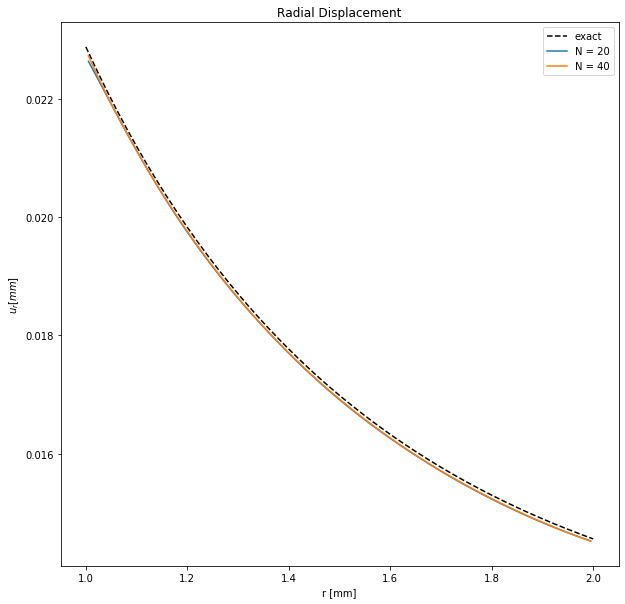

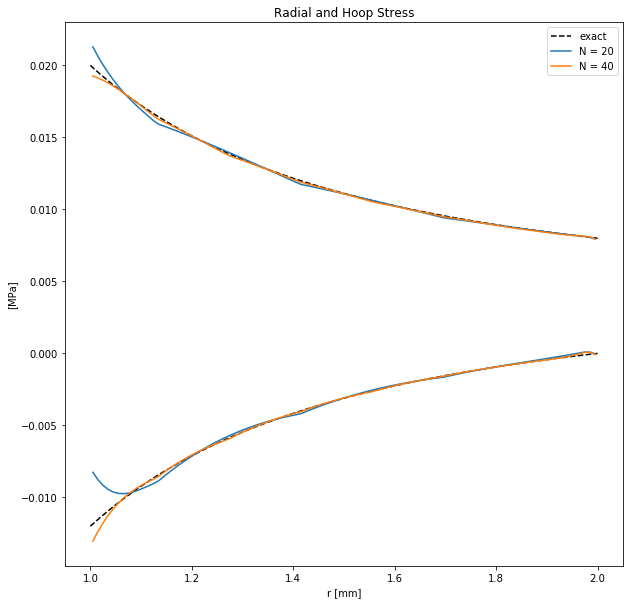

In [27]:
ri = 1
ro = 2
L = 2 * ro
E_b = .00001
nu_b = 0.0
E_a = 1
nu_a = 0.3
N = [20, 40]
Nu = 100
pi = 0.012
n = 100
p = 2
q = 3
pg = 1
nref = 2
nqref = 4

vals2d = {}
vals1d = {"r" : "r", "sigmarr" : "$\sigma_{rr}$", "sigmatt" : "$\sigma_{\\theta \\theta}$", "ur" : "$u_{r}$"}
cases = ["N = 20", "N = 40"]
figs = {"disp" : "Radial Displacement", "stress" : "Radial and Hoop Stress"}
plots = {"disp" : ["ur"], "stress" : ["sigmarr", "sigmatt"]}
xlabels = {"disp" : "r [mm]", "stress" : "r [mm]"}
ylabels = {"disp" : "$ u_{r} [mm]$", "stress" : "[MPa]"}

results = RunImmersedThickWalledCylinder(ri, ro, L, E_b, nu_b, E_a, nu_a, pi, N, N, Nu, p, q, pg, nref, nqref, n, vals1d, vals2d)
exact = Exact(ri, ro, pi, E_a, nu_a, n, vals1d)
Plot(figs, plots, xlabels, ylabels, results, exact, vals1d)

In [37]:
# inputs
ri = 1
ro = 2
E_b = .000001
nu_b = 0.0
E_a = 1
nu_a = .3
pi = 0.012
Nb = 10
Na = 10
Nt = 15
epsilon = ri / 10
p = 2
delta = 0

In [24]:
# build mesh
omega = function.Namespace()
rb = np.linspace(epsilon, ri, Nb + 1)
ra = np.linspace(ri, ro, Na + 1)
r = np.concatenate([rb, ra[1::]])
t = np.linspace(0, np.pi/2, Nt + 1)
omega_topo, omega.uv = mesh.rectilinear([t,r])
omega.x_i = '<uv_1 cos(uv_0) , uv_1 sin(uv_0) >_i'

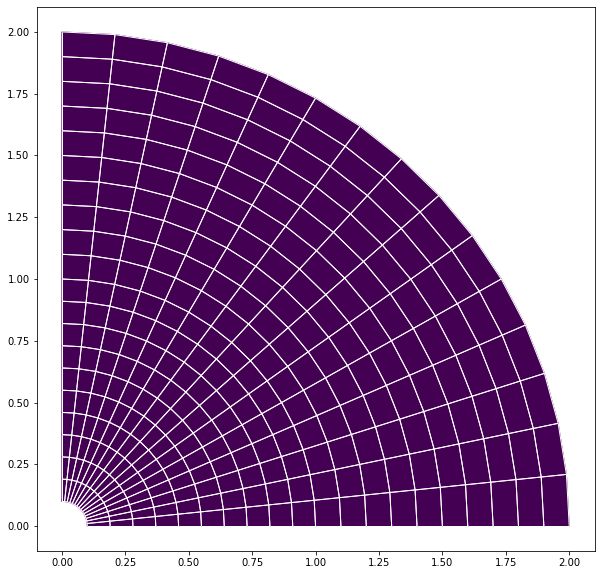

In [25]:
# Plot Mesh
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sample = omega_topo.sample('bezier', 2)
x_vals, vals = sample.eval([omega.x,0])
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

In [26]:
# Build basis
def BuildBasis(degree):
    N = Nb + Na
    knotvals = [t, r]
    knotmults = [np.ones(Nt+1,dtype=int), np.ones(N+1,dtype=int)]
    knotmults[0][0] = degree
    knotmults[0][-1] = degree
    knotmults[0][Nb] = degree
    return omega_topo.basis('spline', degree=degree, knotvalues = knotvals, knotmultiplicities=knotmults)

omega.basis = BuildBasis(p)
#omega.matbasis = BuildBasis(mat_degree)

In [27]:
# build material properties functions
class YoungsModulus(function.Pointwise):
    @staticmethod
    def evalf(x,y):
        val0 = E_b * (1.0 - np.heaviside(x**2 + y**2 - ri**2 + delta , 1))
        val1 = E_a * np.heaviside(x**2 + y**2 - ri**2 + delta, 1)
        return val0 + val1
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)
    
class PoissonRatio(function.Pointwise):
    @staticmethod
    def evalf(x,y):
        val0 = nu_b * (1.0 - np.heaviside(x**2 + y**2 - ri**2 + delta , 1))
        val1 = nu_a * np.heaviside(x**2 + y**2 - ri**2 + delta, 1)
        return val0 + val1
    def _derivative(self, var, seen):
        return np.zeros(self.shape+var.shape)
    
omega.E = YoungsModulus(omega.x[0], omega.x[1])
omega.nu = PoissonRatio(omega.x[0], omega.x[1])

omega.mu = 'E / (2 (1 + nu))'
omega.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'

#if project:
#    omega.mu = omega_topo.projection(omega.mu, onto=omega.matbasis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3))
#    omega.lmbda = omega_topo.projection(omega.lbmda, onto=omega.matbasis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(3))

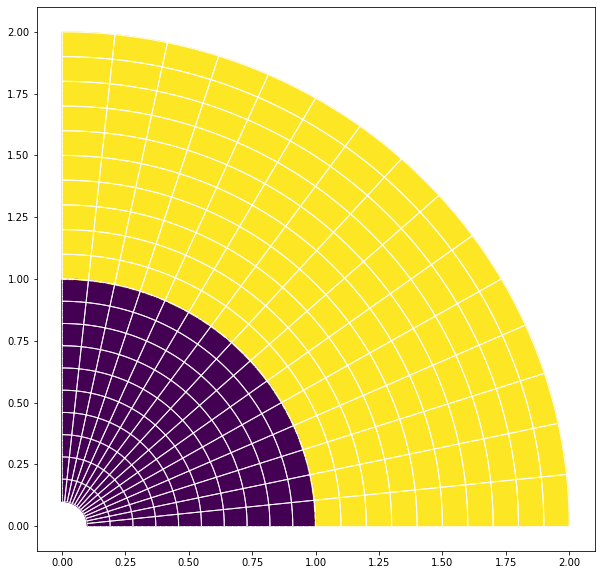

In [28]:
# Plot Mesh
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sample = omega_topo.sample('bezier', 20)
x_vals = sample.eval(omega.x)
E_vals = sample.eval(omega.E)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, E_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()


In [29]:
# Extract the blood subset topology
N = Nb + Na
blood_subtopo = topology.SubsetTopology(omega_topo, [omega_topo.references[i * Nt + j] if j < Nb else omega_topo.references[i].empty for i in range(Nt) for j in range(N)])

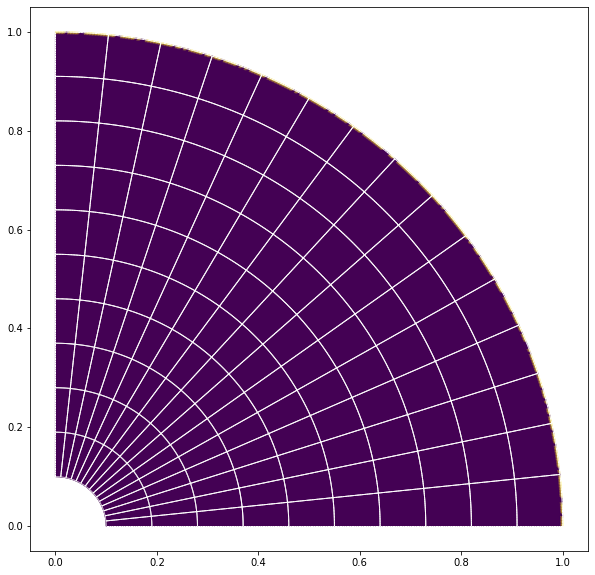

In [30]:
# Plot Blood Mesh
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sample = blood_subtopo.sample('bezier', 20)
x_vals = sample.eval(omega.x)
E_vals = sample.eval(omega.E)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, E_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()


In [31]:
#  Extract loaded boundary
def BloodTopBoundary(boundary_topo, geom, Rb, TOL):
    verts = boundary_topo.sample('bezier', 2).eval(geom)
    ielems = []
    k = 0
    for i in range(len(boundary_topo)):
        isOnBoundary = True
        for j in range(2):
            if np.abs(verts[k][0]**2 + verts[k][1]**2 - Rb**2) > TOL:
                isOnBoundary = False
                k += 1
                break
            k += 1
        if isOnBoundary:
            ielems.append(i)
    ielems = np.array(ielems,dtype=int)
    return topology.SubsetTopology(boundary_topo, [boundary_topo.references[i] if i in ielems else boundary_topo.references[i].empty for i in range(len(boundary_topo.references))])
blood_subtopo_loaded_boundary = BloodTopBoundary(blood_subtopo.boundary, omega.x, ri, .0001)

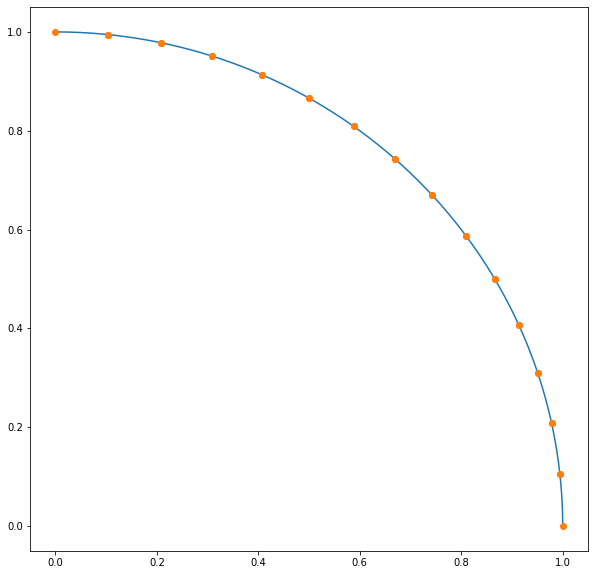

In [32]:
# Plot Blood Mesh
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sample = blood_subtopo_loaded_boundary.sample('bezier', 20)
sample_verts = blood_subtopo_loaded_boundary.sample('bezier', 2)
x_vals = sample.eval(omega.x)
verts = sample_verts.eval(omega.x)
ax.plot(x_vals[:,0], x_vals[:,1])
ax.plot(verts[:,0], verts[:,1], 'o')
plt.show()

In [33]:
# Build Blood Mesh
blood = function.Namespace()
blood_topo, blood.uv = mesh.rectilinear([t,rb])
blood.x_i = '<uv_1 cos(uv_0) , uv_1 sin(uv_0) >_i'

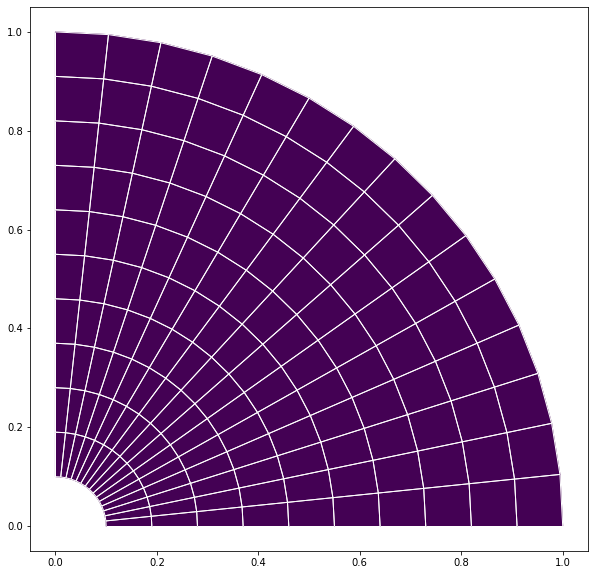

In [34]:
# Plot Blood Mesh
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sample = blood_topo.sample('bezier', 2)
x_vals, vals = sample.eval([omega.x,0])
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

In [35]:
# Build BLood Basis
blood.basis = blood_topo.basis('spline', degree=p)

In [52]:
# Solve the Blood problem
blood.E = E_b
blood.nu = nu_b
blood.mu = 'E / (2 (1 + nu))'
blood.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'
blood.ubasis = blood.basis.vector(2)
blood.u_i = 'ubasis_ni ?alpha_n'
blood.strain_ij = '(u_i,j + u_j,i) / 2'
blood.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
blood.X_i = 'x_i + u_i'
blood.disp = 'sqrt(u_i u_i)'
blood.r = 'sqrt( x_i x_i )'
blood.cos = 'x_0 / r'
blood.sin = 'x_1 / r'
blood.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
blood.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
blood.du_i = 'Qinv_ij u_j'
blood.sigmatt = 'sigma_11'
blood.sigmarr = 'sigma_00'
blood.ur = 'du_0'
blood.pi = pi
# Kblood = blood_topo.integral('ubasis_ni,j stress_ij d:x' @ blood, degree = np.max([1, 2 * (basis_degree-1) + mat_degree]))
Kblood = blood_topo.integral('ubasis_ni,j stress_ij d:x' @ blood, degree=7)
#Fblood = blood_topo.boundary["top"].integral('pi n_i ubasis_ni d:x' @ blood, degree=p)
Fblood = blood_topo.boundary["top"].integral('pi n_i ubasis_ni d:x' @ blood, degree=5)
sqr_blood  = blood_topo.boundary['left'].integral('u_1 u_1 d:x' @ blood, degree = 2 * p)
sqr_blood += blood_topo.boundary['right'].integral('u_0 u_0 d:x' @ blood, degree = 2 * p)
cons_blood = solver.optimize('alpha', sqr_blood, droptol=1e-11)
alpha = solver.solve_linear('alpha', residual=Kblood-Fblood, constrain=cons_blood)

optimize > constrained 24/408 dofs
optimize > optimum value 0.00e+00
solve > solving 384 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-17


In [53]:
# Sample Blood Problem Solution
nsamples = 20
sample = blood_topo.sample('bezier',nsamples)
x_vals = sample.eval(blood.x)
ur_vals = sample.eval(blood.ur, alpha=alpha)
sigmarr_vals = sample.eval(blood.sigmarr, alpha=alpha)
sigmatt_vals = sample.eval(blood.sigmatt, alpha=alpha)

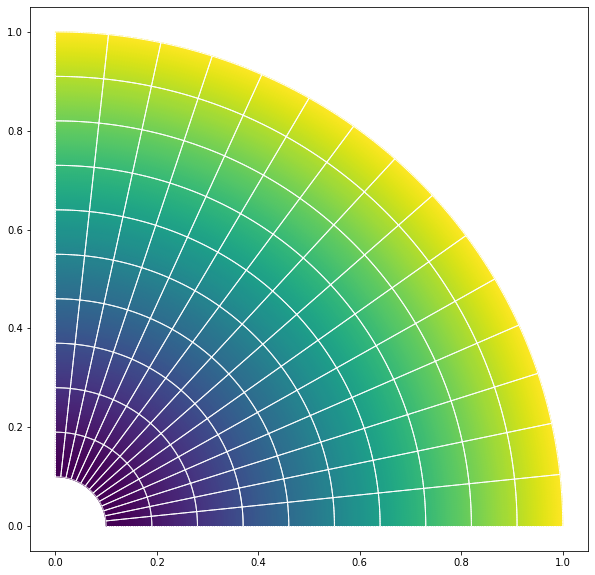

In [54]:
# Plot radial displacement from blood problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, ur_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

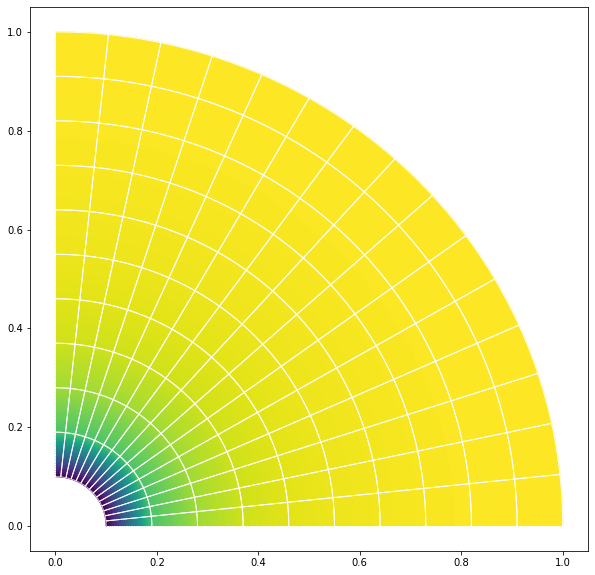

In [55]:
# Plot radial stress from blood problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, sigmarr_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

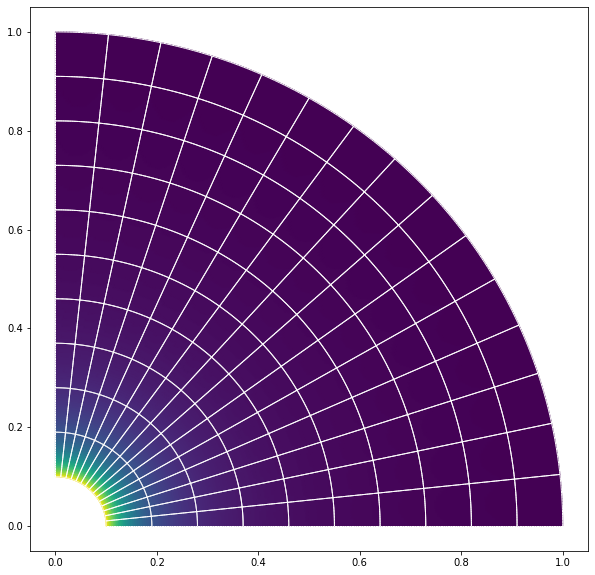

In [56]:
# Plot hoop stress from blood problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, sigmatt_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

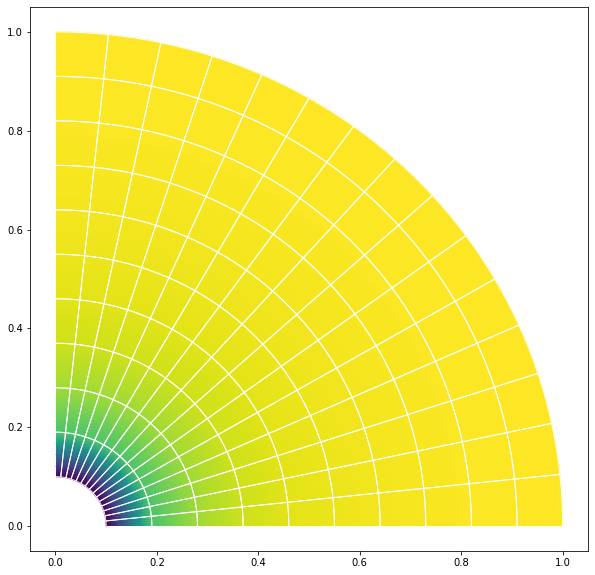

In [72]:
# Plot stress tensor from blood problem on blood topo
sample = blood_subtopo.sample('bezier', 5)
x_vals, vals = sample.eval(['x_i', 'sigma_00'] @ blood, alpha=alpha)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

In [62]:
# Solve Full Problem
omega.ubasis = omega.basis.vector(2)
omega.u_i = 'ubasis_ni ?lhs_n'
omega.strain_ij = '(u_i,j + u_j,i) / 2'
omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
omega.X_i = 'x_i + u_i'
omega.disp = 'sqrt(u_i u_i)'
omega.r = 'sqrt( x_i x_i )'
omega.cos = 'x_0 / r'
omega.sin = 'x_1 / r'
omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
omega.du_i = 'Qinv_ij u_j'
omega.sigmatt = 'sigma_11'
omega.sigmarr = 'sigma_00'
omega.ur = 'du_0'

# Stiffness matrix
#K = omega_topo.integral('ubasis_ni,j stress_ij d:x' @ omega, degree = np.max([1, 2 * (basis_degree-1) + mat_degree]))
K = omega_topo.integral('ubasis_ni,j stress_ij d:x' @ omega, degree = 7)
# Force Vector
blood.fullbasis = omega.ubasis
#F = blood_topo.integral('fullbasis_ni,j stress_ij d:x' @ blood(alpha=alpha), degree=np.max([1, 2 * (basis_degree-1) + mat_degree]))
F = blood_subtopo.integral('fullbasis_ni,j stress_ij d:x' @ blood(alpha=alpha), degree=5)

# Constrain Omega
sqr  = blood_topo.boundary['left'].integral('u_1 u_1 d:x' @ omega, degree = 2 * p)
sqr += blood_topo.boundary['right'].integral('u_0 u_0 d:x' @ omega, degree = 2 * p)
cons = solver.optimize('lhs', sqr, droptol=1e-11)

# Solve
lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

optimize > constrained 24/792 dofs
optimize > optimum value 0.00e+00
solve > solving 768 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-16


In [63]:
# Sample Full Problem Solution
nsamples = 20
sample = omega_topo.sample('bezier',nsamples)
x_vals = sample.eval(omega.x)
ur_vals = sample.eval(omega.ur, lhs=lhs)
sigmarr_vals = sample.eval(omega.sigmarr, lhs=lhs)
sigmatt_vals = sample.eval(omega.sigmatt, lhs=lhs)

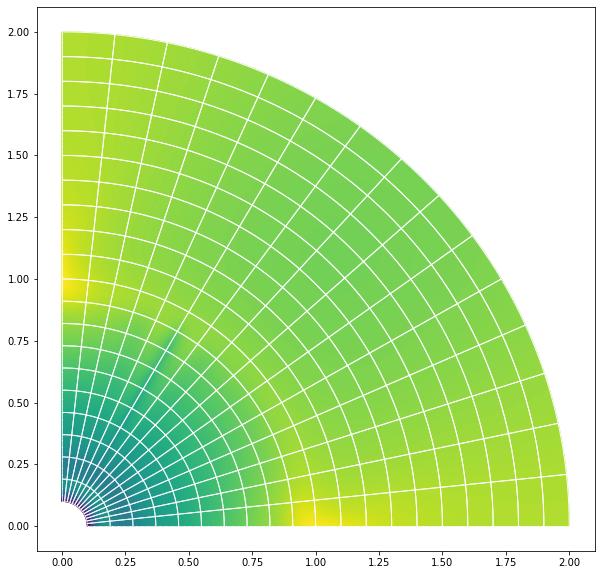

In [64]:
# Plot radial displacement from full problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, ur_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

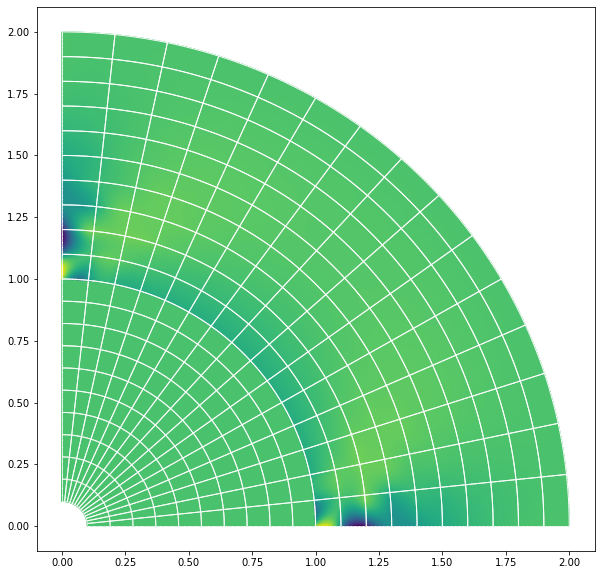

In [65]:
# Plot radial stress from full problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, sigmarr_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()

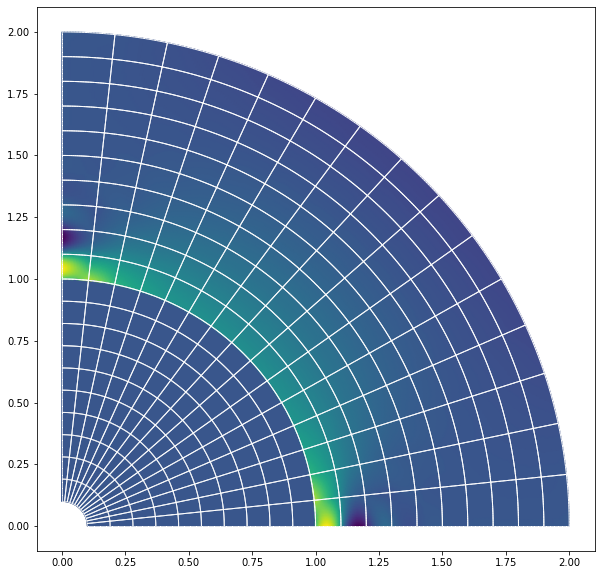

In [66]:
# Plot hoop stress from full problem
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.tripcolor(x_vals[:,0], x_vals[:,1], sample.tri, sigmatt_vals, shading='gouraud', rasterized=True)
ax.add_collection(collections.LineCollection(x_vals[sample.hull], colors='w', linewidth=1, alpha=1))
plt.show()